In [1]:
import pandas as pd 
from PIL import Image
import numpy as np
import os

img_list = []
label_list = []
for dirname, _, filenames in os.walk('D:/Computer Vision/data/vehicle-classification-dataset/train/train'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        image = dirname + '\\' + filename
        # print(img)
        image= Image.open(image)
        image = image.resize((64,64))
        gray_image = image.convert('L')
        image= np.array(gray_image)
        img_list.append(image)
        # label_list.append(dirname.split("\\")[-1].split("\\")[0])
        label_list.append(dirname.split("\\")[-1])
data = pd.DataFrame({'image':img_list,'label':label_list})

In [2]:
classes_names = data['label'].unique()
print(classes_names)

['Ambulance' 'Bicycle' 'Bus' 'Car' 'Helicopter' 'Motorcycle' 'Tank' 'Taxi'
 'Truck' 'Van']


In [3]:
X = np.array(img_list)
print(X.shape)
y = np.array(label_list)
print(y.shape)

(18416, 64, 64)
(18416,)


In [4]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [5]:
# One hot encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_label_train = le.fit_transform(y_train)
y_label_val = le.transform(y_val)

from keras.utils import to_categorical
y_train = to_categorical(y_label_train)
y_val = to_categorical(y_label_val)

# Normalization
X_train = X_train/255
X_val = X_val/255

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential()
    model.add(Conv2D(64,(3,3),input_shape=(64,64,1),activation='relu',padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(64,(3,3),input_shape=(64,64,1),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128,(3,3),input_shape=(64,64,1),activation='relu',padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(128,(3,3),input_shape=(64,64,1),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(3,3),input_shape=(64,64,1),activation='relu',padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(128,(3,3),input_shape=(64,64,1),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.35))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=metrics)
    return model

In [7]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [8]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                        

In [9]:
import tempfile

initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [10]:
# Instead of using oversampling method, I will use class weights
# Because oversampling method will increase the training time and it will not be good for the model
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

# Calculate class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight("balanced",np.unique(y_label_train), y_label_train)
class_weights = dict(zip(np.unique(y_label_train),class_weights))
class_weights

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

In [10]:
model = make_model()
model.load_weights(initial_weights)

weighted_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight={0: 34.87, 1: 2.85, 2: 2.16, 3: 0.68, 4: 6.89, 5: 1.54, 6: 22.35, 7: 6.16, 8: 2.26, 9: 4.14})

# save model
model.save('model.h5')

Epoch 1/100


: 

: 

In [ ]:
# Check training history
import matplotlib.pyplot as plt
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='green', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [ ]:
# Evaluate metrics

train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_val, batch_size=BATCH_SIZE)

In [68]:
# Model_3 with Batch Normalization

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

model_3 = Sequential()
model_3.add(Conv2D(64,(3,3),input_shape=(28,28,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())

model_3.add(Conv2D(64,(3,3),input_shape=(28,28,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(128,(3,3),input_shape=(28,28,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())

model_3.add(Conv2D(128,(3,3),input_shape=(28,28,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128,(3,3),input_shape=(28,28,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())

model_3.add(Conv2D(128,(3,3),input_shape=(28,28,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.35))

model_3.add(Flatten())

model_3.add(Dense(256, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(17, activation='softmax'))

model_3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [73]:
model_3.summary()
history_3 = model_3.fit(X_train, y_train, epochs = 30, verbose = 1, validation_data = (X_test, y_test))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 28, 28, 64)        1792      
                                                                 
 batch_normalization_21 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_22 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                      

In [74]:
model_3.save('my_model.h5')

In [77]:
# Recreate the exact same model, including its weights and the optimizer
my_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture|
my_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 28, 28, 64)        1792      
                                                                 
 batch_normalization_21 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_22 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                      

In [78]:
loss, acc = my_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

176/176 - 6s - loss: 0.9533 - accuracy: 0.7909 - 6s/epoch - 34ms/step
Restored model, accuracy: 79.09%


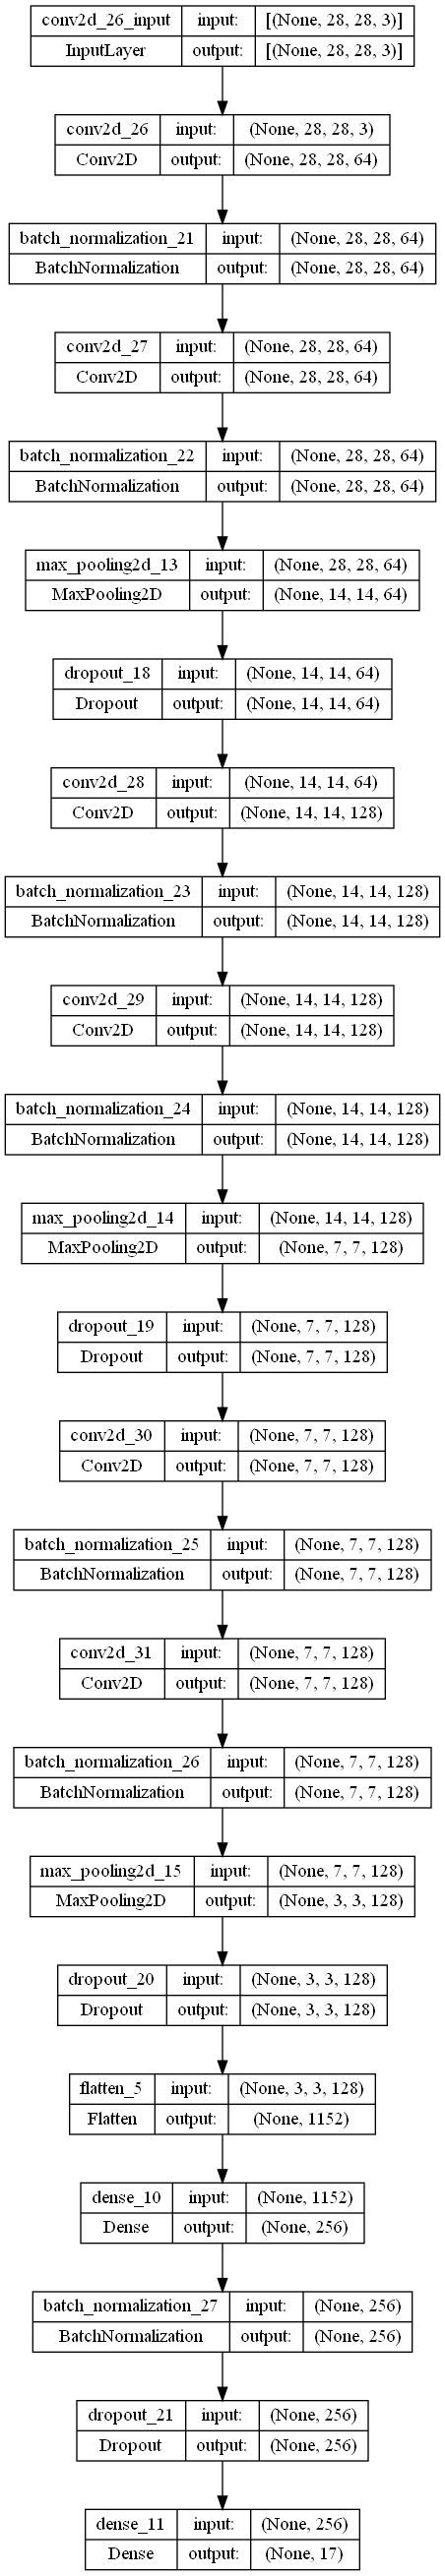

In [80]:
from tensorflow.keras.utils import plot_model
plot_model(my_model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

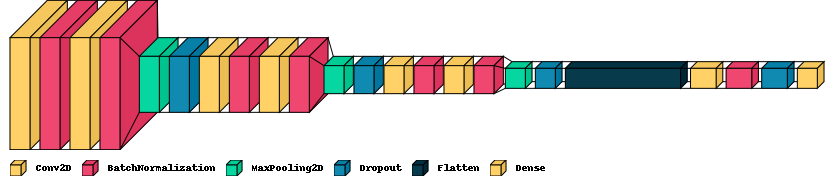

In [82]:
import visualkeras
visualkeras.layered_view(model_3, legend=True)

In [76]:
import tensorflow as tf 
from tensorflow import keras 
import os 

print(tf.version.VERSION)

2.10.0


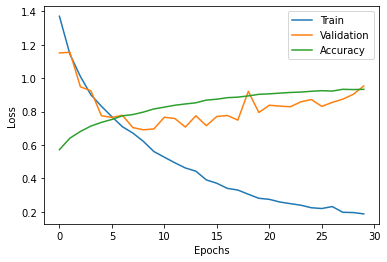

In [83]:
# Plotting the loss and accuracy
import matplotlib.pyplot as plt

def plotloss(history_3):
    plt.plot(history_3.history['loss'])
    plt.plot(history_3.history['val_loss'])
    plt.plot(history_3.history['accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation', 'Accuracy'])
    plt.show()    
plotloss(history_3)

In [86]:
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  
   # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [ ]:
# Make predictions with the most recent model
y_probs = my_model.predict(X_test) # "probs" is short for probabilities

# View the first 5 predictions
y_probs[:5]

In [90]:
class_names = ['Ambulance', 'Barge', 'Bicycle', 'Boat', 'Bus', 'Car', 'Cart', 'Caterpillar','Helicopter',
            'Limousine', 'Motorcycle', 'Segway', 'Snowmobile', 'Tank', 'Taxi', 'Truck', 'Van']

# How many classes are there (this'll be our output shape)?
len(class_names)

17

In [91]:
# See the predicted class number and label for the first example
y_probs[0].argmax(), class_names[y_probs[0].argmax()]

(3, 'Boat')

In [92]:
# See the predicted class number and label for the first example
y_probs[1].argmax(), class_names[y_probs[1].argmax()]

(15, 'Truck')

In [93]:
# Convert all of the predictions from probabilities to labels
y_preds = y_probs.argmax(axis=1)

# View the first 10 prediction labels
y_preds[:10]

array([ 3, 15,  3,  8, 10,  2, 10,  3,  3,  4], dtype=int64)

In [ ]:
y_test[:10]

In [98]:
y_test = y_test.argmax(axis=1)

In [ ]:
# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_test, # ground truth test labels 
                 y_pred=y_preds) # predicted labels

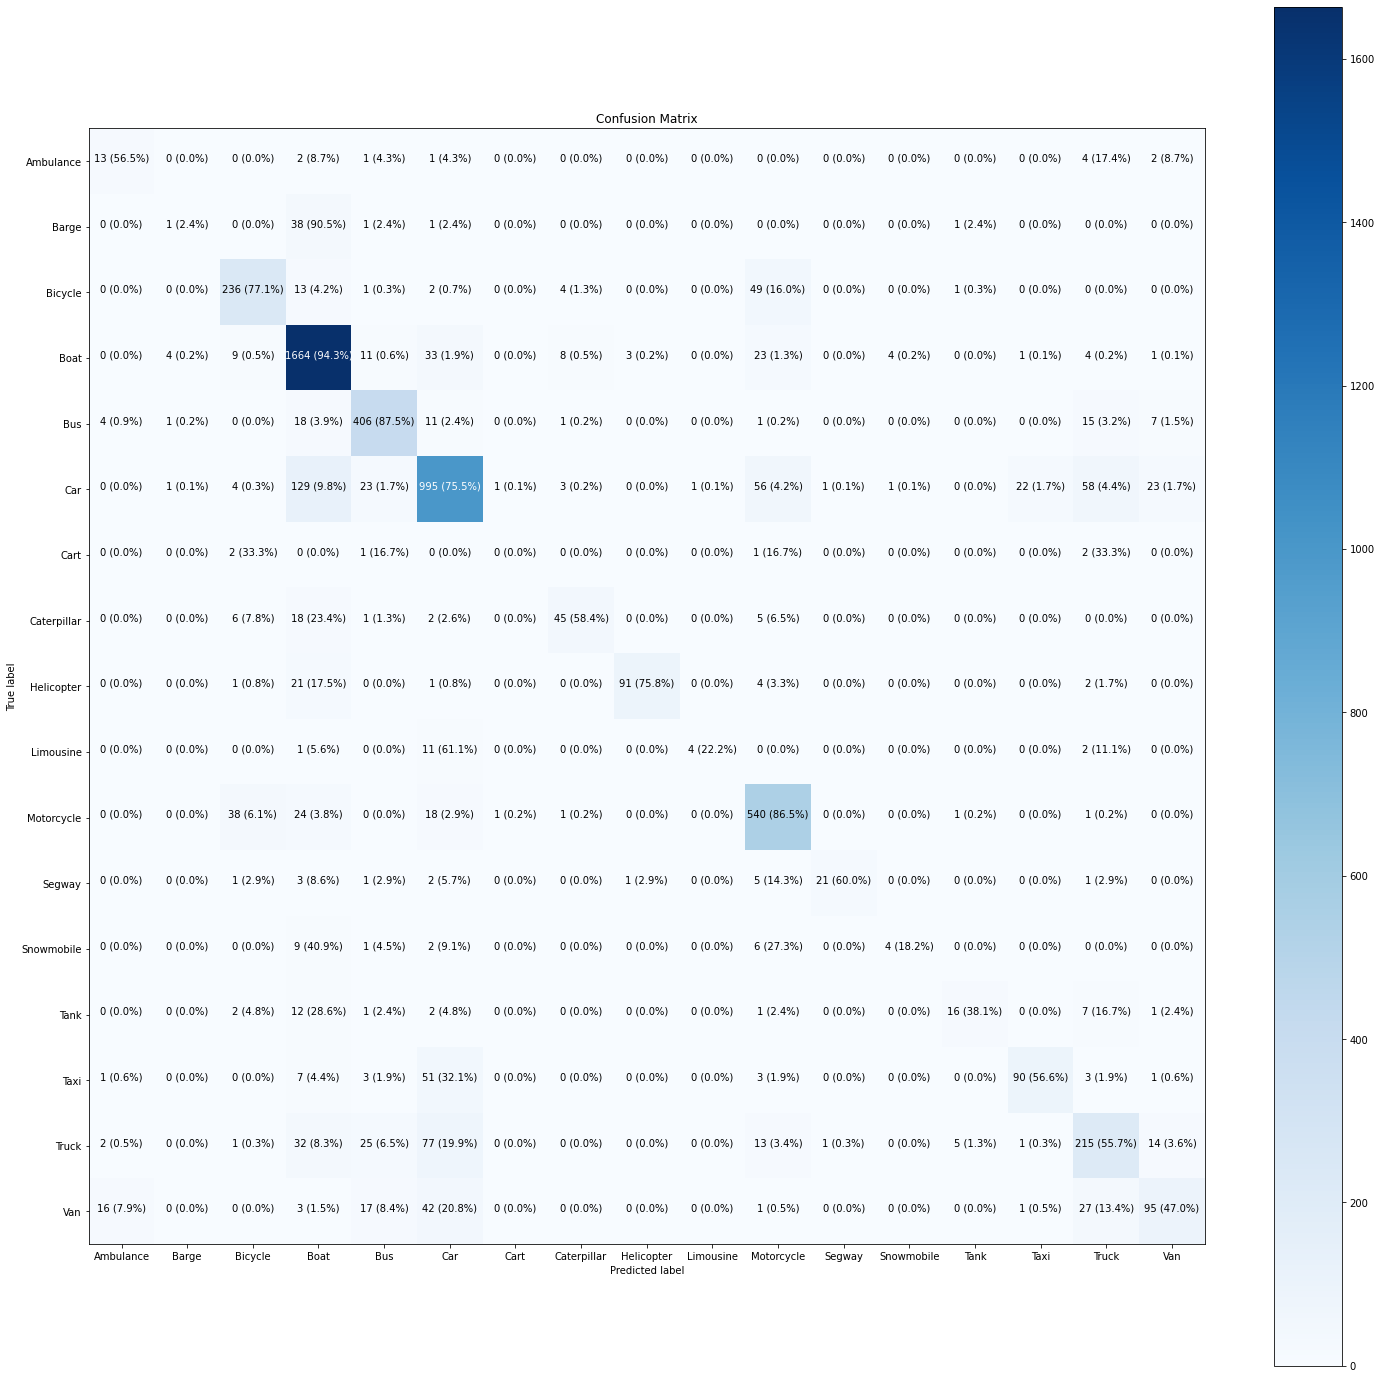

In [105]:
# Make a prettier confusion matrix
make_confusion_matrix(y_true=y_test, 
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(25, 25),
                      text_size=10)

In [208]:
import cv2 

def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (28, 28))
    img = img / 255.0
    return img

def get_prediction(image_path):
    img = load_image(image_path)
    img = np.expand_dims(img, axis=0)
    prediction = my_model.predict(img)
    class_name = class_names[prediction.argmax()]
    return class_name 

# Get the probability of the prediction
def get_probability(image_path):
    img = load_image(image_path)
    img = np.expand_dims(img, axis=0)
    prediction = my_model.predict(img)
    probability = np.max(prediction)
    return probability 


In [206]:
# Plotting an image with its predicted class name, ground truth label, probability of predicted class and ground truth class (if available), and whether the prediction was correct or not
def plot_image_prediction_ground_truth_prob(image_path, label, ground_truth, prob):
    img = load_image(image_path)
    plt.imshow(img)
    plt.title(f"Prediction: {label}, Ground truth: {ground_truth}, Prob: {prob}")
    plt.axis(False)

1/1 [==============================] - 0s 26ms/step


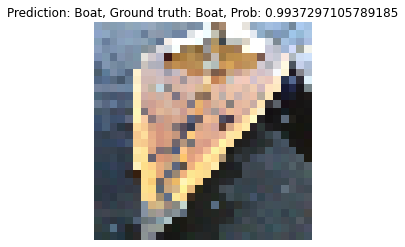

In [209]:
plot_image_prediction_ground_truth_prob('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007956.jpg',
                                        get_prediction('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007956.jpg'),
                                        'Boat',
                                        get_probability('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007956.jpg'))

1/1 [==============================] - 0s 33ms/step


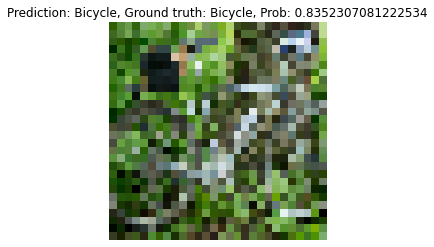

In [210]:
plot_image_prediction_ground_truth_prob('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007954.jpg',
                                        get_prediction('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007954.jpg'),
                                        'Bicycle',
                                        get_probability('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007954.jpg'))

1/1 [==============================] - 0s 29ms/step


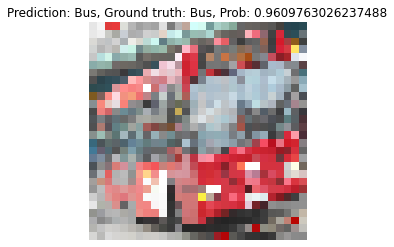

In [211]:
plot_image_prediction_ground_truth_prob('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007953.jpg',
                                        get_prediction('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007953.jpg'),
                                        'Bus',
                                        get_probability('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007953.jpg'))

1/1 [==============================] - 0s 21ms/step


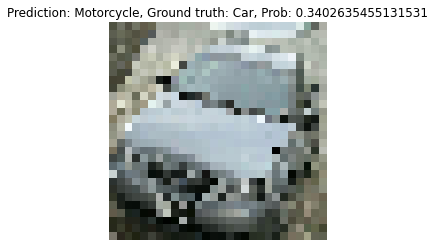

In [212]:
plot_image_prediction_ground_truth_prob('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000017.jpg',
                                        get_prediction('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000017.jpg'),
                                        'Car',
                                        get_probability('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000017.jpg'))

1/1 [==============================] - 0s 13ms/step


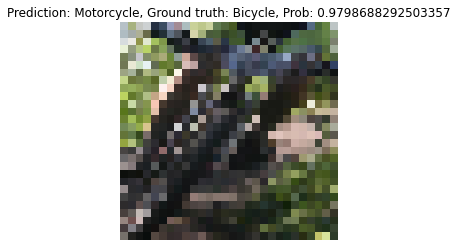

In [213]:
plot_image_prediction_ground_truth_prob('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007926.jpg',
                                        get_prediction('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007926.jpg'),
                                        'Bicycle',
                                        get_probability('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007926.jpg'))

1/1 [==============================] - 0s 23ms/step


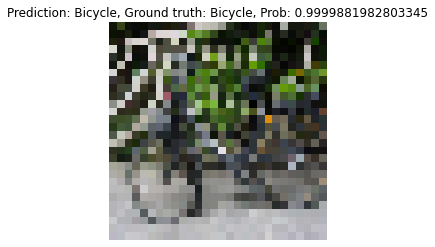

In [214]:
plot_image_prediction_ground_truth_prob('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000050.jpg',
                                        get_prediction('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000050.jpg'),
                                        'Bicycle',
                                        get_probability('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000050.jpg'))

1/1 [==============================] - 0s 22ms/step


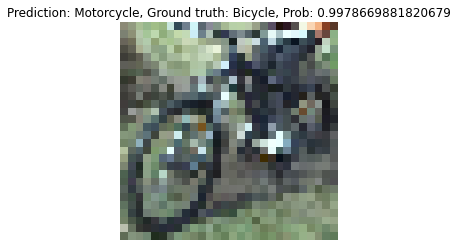

In [216]:
plot_image_prediction_ground_truth_prob('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000100.jpg',
                                        get_prediction('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000100.jpg'),
                                        'Bicycle',
                                        get_probability('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000100.jpg'))

1/1 [==============================] - 0s 35ms/step


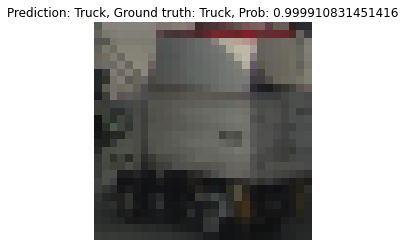

In [218]:
plot_image_prediction_ground_truth_prob('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000104.jpg',
                                        get_prediction('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000104.jpg'),
                                        'Truck',
                                        get_probability('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000104.jpg'))

1/1 [==============================] - 0s 24ms/step


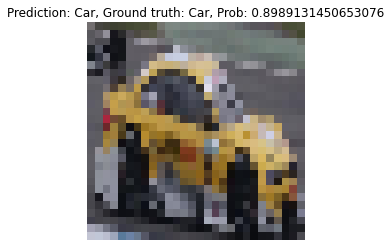

In [219]:
plot_image_prediction_ground_truth_prob('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007939.jpg',
                                        get_prediction('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007939.jpg'),
                                        'Car',
                                        get_probability('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/007939.jpg'))

1/1 [==============================] - 0s 29ms/step


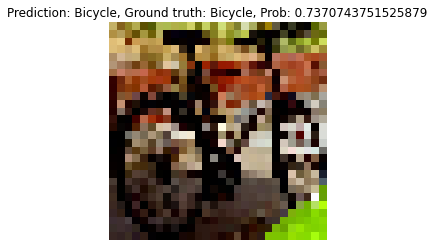

In [220]:
plot_image_prediction_ground_truth_prob('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000024.jpg',
                                        get_prediction('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000024.jpg'),
                                        'Bicycle',
                                        get_probability('D:/Computer Vision/data/vehicle-classification-dataset/test/testset/000024.jpg'))